In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import shapiro
import scipy.optimize as sco
import scipy.interpolate as sci
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

C:\Users\Minh Anh Vu\AppData\Roaming\Python\Python38\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Minh Anh Vu\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Minh Anh Vu\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Jupyter structure
### 1. Overview 
    1.1. Portfolio assets
    1.2. Data preparation.

### 2. Time series analysis
    2.1. Descriptive statistics
        2.1.1. Price movement 
        2.1.2. Average return and volatility
        2.1.3. Correlation matrix
    2.2. Predictive model - ARIMA
        2.2.1. Stationarity test
        2.2.2. Model parameters identification (ACF and PACF plot)
        2.2.3. Regression results
        
### 3. Portfolio optimization
    3.1. Normality tests
    3.2. Portfolio return and volatility defining
    3.3. Efficient portfolios
        3.3.1. Minimum variance portfolio
        3.3.2. Optimal portfolio by maximizing Sharpe ratio
        3.3.3. Tangent portfolio identification
    3.4. Roy's safety-first criterion
### 4. Discussion

## 1. Overview
### 1.1. Portfolio assets
### Overview about the assets
- Our porfolio comprises 2 ETFs and 1 ETN, whose prices are linked to the performance of 2 stock indexes and 1 volatility index. 
> - XVZ -  S&P 500 Dynamic VIX Futures TM Total Return Index
> - EXX5.DE - iShares Dow Jones U.S. Select Dividend 
> - IUS3.DE - iShares S&P SmallCap 600
- A total of 716 observations for each asset (equivalent to 3 years timeframe) are collected. 

### 1.2. Data preparation

In [2]:
#Import adjusted closing price 
tickers = ["EXX5.DE", "XVZ", "IUS3.DE"]
Assets = yf.download(tickers, start= "2018-06-01", end="2021-06-01")
Exchange_rate = yf.download("USDEUR=X", start= "2018-06-01", end="2021-06-01")

#Convert prices into EUR 
Assets = Assets["Adj Close"]
Assets["XVZ"] = Assets["XVZ"]*Exchange_rate["Adj Close"]
Assets = Assets.dropna()

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed


# 2. Time Series Analysis
## 2.1 Descriptive statistics.

In [3]:
Assets.describe().round(2)

,EXX5.DE,IUS3.DE,XVZ
count,716.00,716.00,716.00
mean,59.77,57.30,23.60
std,6.10,7.85,8.29
min,41.38,36.62,11.72
25%,55.64,52.43,16.26
50%,60.52,56.73,17.40
75%,63.63,60.60,32.94
max,72.64,77.73,43.71


### 2.1.1. Price movement 

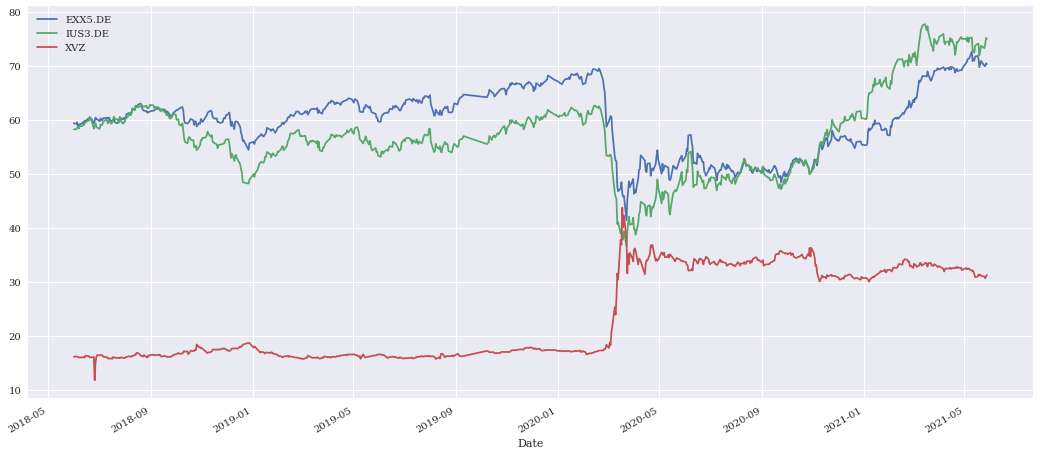

In [4]:
Assets.plot(figsize = (18,8));

- XVZ's price moved in an opposite direction with respect to EXX5.DE and IUS3.DE. During the market crash in March 2020, XVZ shoot up more than 100% while EXX5.DE and IUS3.DE plunged to an all-time low. This is explained by the opposite reaction to market uncertainty of volatility index and stock index: VIX with respect to Down Joins and S&P. As demand for hedging risk increased, VIX performed well while Down Joins and S&P plummeted due to the pessimistic view of investors

- Market started to recover after the first batch of vaccine was released in November 2020. From the graph, we can see the small cap companies recoverd far faster than the large ones due to the flexibility in management and greater support from the goverment



### 2.1.2. Average returns and volatilities 

In [5]:
# Annualized return
Log_returns = np.log(Assets / Assets.shift(1)).dropna()

entire_period_return = Log_returns.mean()*252
pre_covid_return = Log_returns[:"2020-01-01"].mean()*252
after_covid_return = Log_returns["2020-01-01":].mean()*252


table = pd.DataFrame()
table["Entire period"] = entire_period_return
table["Pre Covid"] = pre_covid_return
table["During Covid"] = after_covid_return
table["Change (times)"] = table["During Covid"]/table["Pre Covid"]
table

,Entire period,Pre Covid,During Covid,Change (times)
EXX5.DE,0.060027,0.086011,0.032624,0.379305
IUS3.DE,0.089247,0.030446,0.151259,4.968126
XVZ,0.234009,0.047977,0.430198,8.966826


In [6]:
# Annualized volatility
entire_period_std = Log_returns.std()*math.sqrt(252)
pre_covid_std = Log_returns[:"2020-01-01"].std()*math.sqrt(252)
after_covid_std = Log_returns["2020-01-01":].std()*math.sqrt(252)


table1 = pd.DataFrame()
table1["Entire period"] = entire_period_std
table1["Pre Covid"] = pre_covid_std
table1["During Covid"] = after_covid_std
table1["Change"] = (after_covid_std/pre_covid_std)
table1


,Entire period,Pre Covid,During Covid,Change
EXX5.DE,0.232733,0.126319,0.307595,2.435062
IUS3.DE,0.268714,0.169252,0.343994,2.032433
XVZ,0.428583,0.375188,0.478728,1.275967


- We compare the returns and volatility of three assets before and after covid using 01.01.2020 (when the first case of Covid-19 was announced) as the division milestone. 

- Rates of return of all three assets became more volatile than the period before the pandemy. The high volatility is the consequence of the market fall and a steep recovery from Nov 2020. 

- The annualized returns of the small cap group (IUS3.DE) and volatility-track security (XVZ) was almost 5 times and 9 times higher than before market crash, repsectively. Conversely, the return rates of the large cap group decreased from 8.6% to 3.2%, mainly due to the fact that the slow recovery rate could not dominate the dip during market crash. 

### 2.1.3 Correlation matrix of returns 

In [7]:
## Correlation for the entire per
round(Log_returns.corr(),2)



,EXX5.DE,IUS3.DE,XVZ
EXX5.DE,1.00,0.88,-0.27
IUS3.DE,0.88,1.00,-0.31
XVZ,-0.27,-0.31,1.00


We plot the rolling correlation over time and  add the static value to the plot as horizontal line

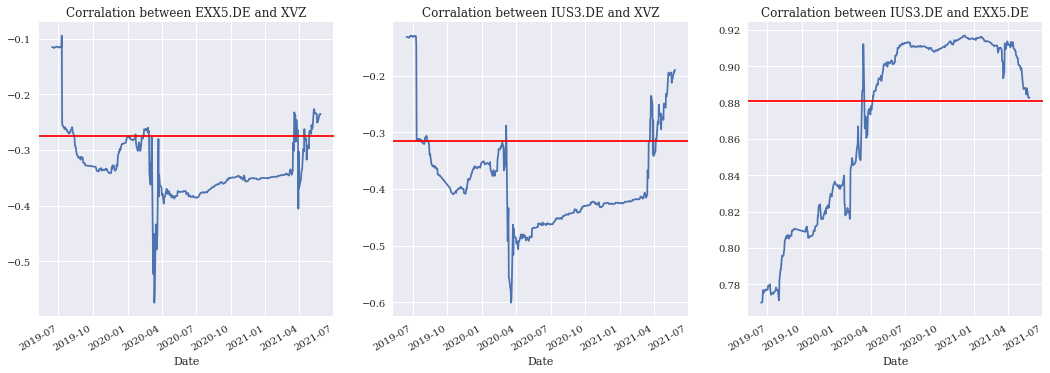

In [8]:
reg_data  = pd.DataFrame({"EXX5.DE":Log_returns["EXX5.DE"], "XVZ":Log_returns["XVZ"]})
reg_data1  = pd.DataFrame({"IUS3.DE":Log_returns["IUS3.DE"], "XVZ":Log_returns["XVZ"]})
reg_data2  = pd.DataFrame({"IUS3.DE":Log_returns["IUS3.DE"], "EXX5":Log_returns["EXX5.DE"]})

fig, axes = plt.subplots(1,3, figsize = (18, 6))
reg_data["EXX5.DE"].rolling(window=252).corr(reg_data['XVZ']).plot(ax=axes[0])
axes[0].axhline(reg_data.corr().iloc[0, 1], c='r')
axes[0].set_title("Corralation between EXX5.DE and XVZ")


reg_data1["IUS3.DE"].rolling(window=252).corr(reg_data['XVZ']).plot(ax=axes[1])
axes[1].axhline(reg_data1.corr().iloc[0, 1], c='r')
axes[1].set_title("Corralation between IUS3.DE and XVZ")

reg_data2["IUS3.DE"].rolling(window=252).corr(reg_data['EXX5.DE']).plot(ax=axes[2])
axes[2].axhline(reg_data2.corr().iloc[0, 1], c='r')
axes[2].set_title("Corralation between IUS3.DE and EXX5.DE");

In [ ]:
- Negative correlation between assets is beneficial in portfolio diversification, which helps to reduce the risk without sacrificing expected return. It is clear that XVZ return is negatively correlated with other assets
- MPT uses average historical correlation of element assets to look forward volatility of the portfolio. This implies the correlation between element assets are stable and predictable. In fact, the correlation between assets can change quite abruptedly if there is a market disruption (outbreak of new diseases) such as our case. 


## 2.2. Predictive  test
### 2.2.1. Stationarity test

Stationarity property plays the key role in multi-regression of time series. A process is considered as stationary if its mean, volatility and autocorrelations between lags are independent of times.
We conclude that our time series (price series) are non stationary for the following reasons:

- Means of three assets are not constant over time, as evidenced by a clear upward trend in price performance
- Unit root test ADF:
     - Null hypothesis: Unit root exists in data series <=> Series is non-stationary
     - As p-value of all three assets > 0.05, we cannot reject the null hypothesis 
- Autocorrelation: the ACF will degrade quickly to zero for a stationary process while decreases slowly for a non-stationary series

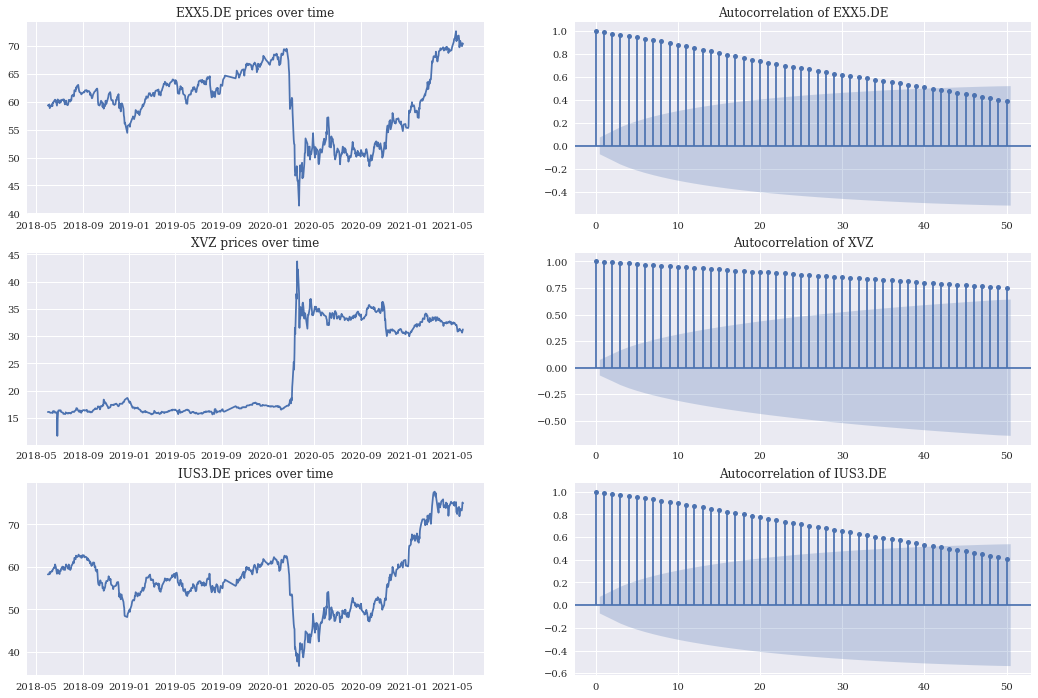

In [9]:
#Autocorrelations plot
fig, axes = plt.subplots(3,2, figsize = (18, 12))
tickers = ["EXX5.DE", "XVZ", "IUS3.DE"]
x = 0
for ticker in tickers:
    axes[x,0].plot(Assets[ticker])
    axes[x,0].set_title(f"{ticker} prices over time", fontsize = 12)
    plot_acf(Assets[ticker], lags = 50, ax = axes[x,1], title = 'Autocorrelation of '+ticker)
    x = x+1 


In [10]:
#Augmented Dickey Fuller test
tickers = ["EXX5.DE", "XVZ", "IUS3.DE"]
for ticker in tickers:
    result = adfuller(Assets[ticker])
    print(ticker)
    print(f"ADF Statistics: {result[0]}")
    print(f"p-value: {result[1]}")
    print("")

EXX5.DE
ADF Statistics: -1.7734950018441114
p-value: 0.3936977986974086

XVZ
ADF Statistics: -1.180322164697081
p-value: 0.6820028277956253

IUS3.DE
ADF Statistics: -1.0619634860117626
p-value: 0.7299997252776053



### 2.2.2. ARIMA model parameters identification (ACF and PACF plot) 

Methodology: 
> ARIMA stands for Autoregressive Integrated Moving Average. The model regress current values on its own lags and the residual errors of the lagged observations. 

- d parameter: indicates the number of differencing to make the series stationary
- p parameter indicates: how many lags - predictors should be used in Auto Regression(AR)
- q parameter: the order of Moving Average(MA)

We will identify the (p,d,q) parameters by using ACF and PACF charts. The rules are: The p value is where the ACF chart crosses the statistical significance threshold for the first time. Similarily, the q value is where the PACF chart crosses the statistical significance threshold for the first time (Taieb, 2018)

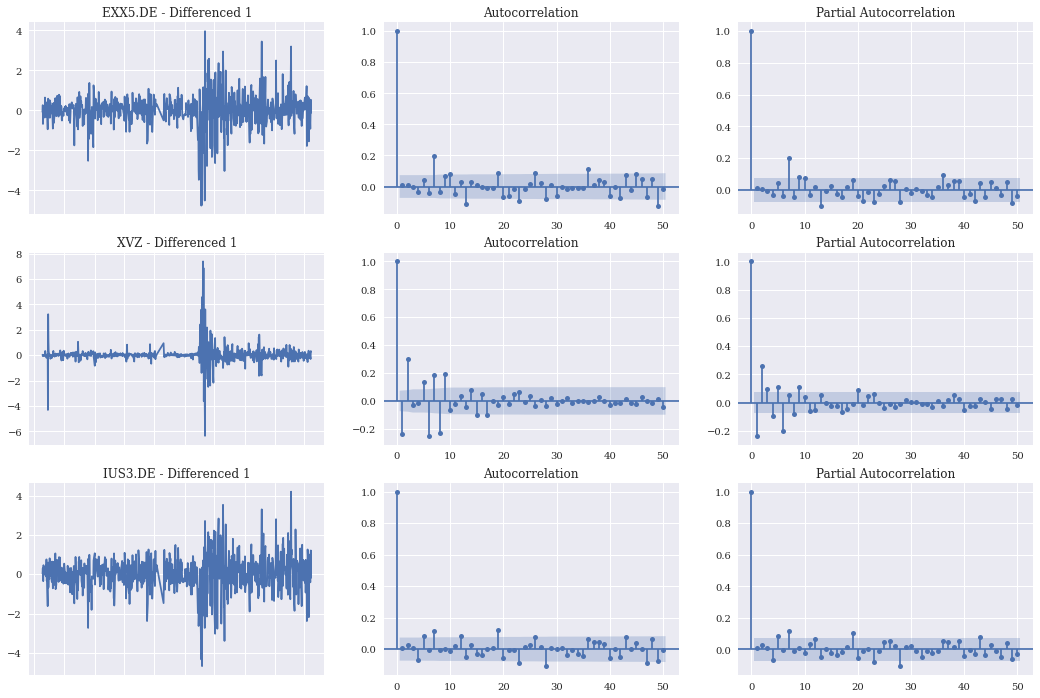

In [12]:
# Plot ACF and PACF to identify AR(p) and MA(q)
tickers = ["EXX5.DE", "XVZ", "IUS3.DE"]
fig, axes = plt.subplots(3,3, figsize = (18,12))
x = 0
for ticker in tickers:
    diffed = Assets[ticker].diff(1).dropna()
    axes[x,0].plot(diffed)
    axes[x,0].set_title(f"{ticker} - Differenced 1")
    plot_acf(diffed, lags = 50, ax=axes[x,1])
    plot_pacf(diffed, lags = 50, ax=axes[x,2])
    axes[x,0].set_xticklabels([])
    x = x+1

Results:
- From ACF graph, MA(p) terms for EXX5.DE, XVZ and IUS3.DE are 7, 1, 7, respectively
- From PACF graph, AR(q) terms for  EXX5.DE, XVZ and IUS3.DE are also 7, 1, 7
- Order of differencing for EXX5.DE, XVZ and IUS3.DE are 1, 1, 1

To sum up, three ARIMA odels will be as follow EXX5.DE(7,1,7), IUS3.DE(7,1,7) and XVZ(1,1,1)

We re-check the order of differencing by using 'ndiff' function. 'ndiff' function runs an ADF test and tels us how many times it is required to make the data set stationary. As shown below, the order of differencing for all three price series is 1. 

In [13]:
print(f'EXX5: {ndiffs(Assets["EXX5.DE"], test = "adf")}')
print(f'XVZ: {ndiffs(Assets["XVZ"], test = "adf")}')
print(f'IUS3: {ndiffs(Assets["IUS3.DE"], test = "adf")}')

EXX5: 1
XVZ: 1
IUS3: 1


### 2.2.3. Regression results and forecasting values
Methodology: 
We split data into train and test groups. We use train data to run time series regression and use test data to validate the accuracy of predictive values.
* Train data: 01/06/2018 - 31/12/2019. 
* Test data: 01/01/2020 - 01/06/2021
* The purpose is to test to predictive power of ARIMA model using the historical performance 3 months prior to the market crash

                             ARIMA Model Results                              
Dep. Variable:              D.EXX5.DE   No. Observations:                  359
Model:                 ARIMA(7, 1, 7)   Log Likelihood                -236.132
Method:                       css-mle   S.D. of innovations              0.461
Date:                Fri, 09 Jul 2021   AIC                            504.264
Time:                        00:21:25   BIC                            566.397
Sample:                             1   HQIC                           528.971
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0172      0.006      2.979      0.003       0.006       0.029
ar.L1.D.EXX5.DE    -1.2139      0.183     -6.646      0.000      -1.572      -0.856
ar.L2.D.EXX5.DE    -0.9966      

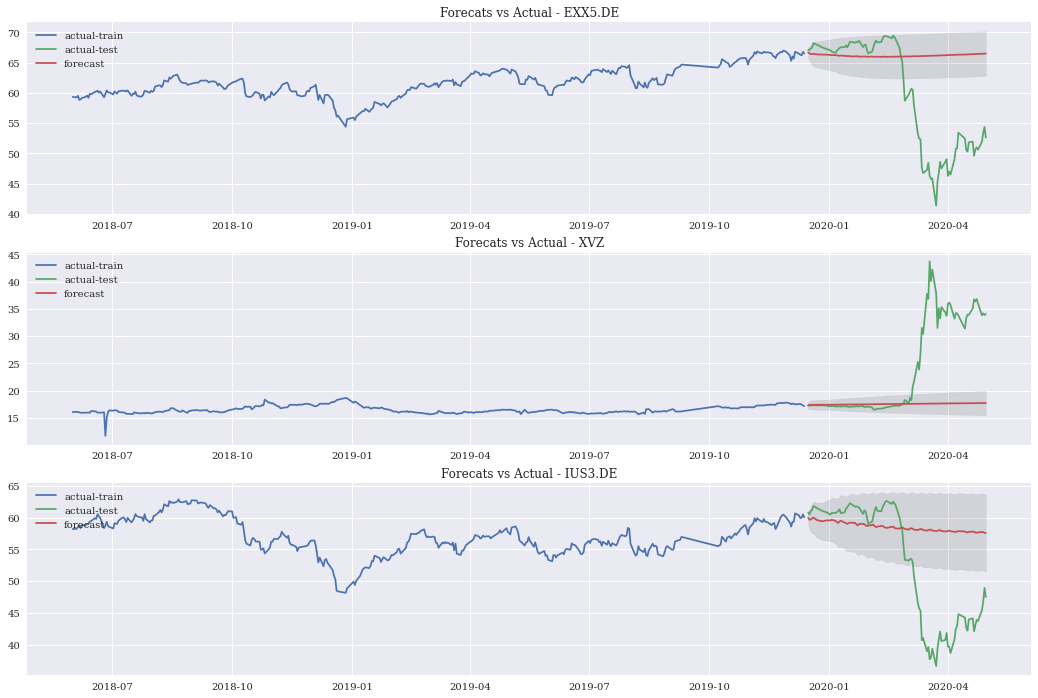

In [14]:
fig, axes = plt.subplots(3, figsize = (18,12))
tickers = ["EXX5.DE", "XVZ", "IUS3.DE"]
x = 0
p = [7, 1, 7]
d = 1
q = [7, 1, 7]

for ticker in tickers:
    n = int(len(Assets[ticker]) * 0.504)
    train = Assets[ticker][:n]
    test = Assets[ticker][n:]
    arima = ARIMA(train, order = (p[x],1,q[x]))
    arima_fit = arima.fit(disp=0)
    fc, se, conf = arima_fit.forecast(90)
    fc = pd.Series(fc, index = test[:90].index)
    lower = pd.Series(conf[:,0], index = test[:90].index)
    upper = pd.Series(conf[:,1], index = test[:90].index)
    axes[x].plot(train, label="actual-train")
    axes[x].plot(test[:90], label="actual-test")
    axes[x].plot(fc, label="forecast")
    axes[x].fill_between(lower.index, lower, upper, color = "k", alpha = 0.1)
    axes[x].set_title(f"Forecats vs Actual - {ticker}")
    axes[x].legend(loc = "upper left");
    print(arima_fit.summary())
    x = x+1

Results and implication:
* The coefficients of first lags are significant at 5% level for all three assets, revealing an autocorrelation of returns. In other words, this result rejects the existence of efficient market for the train period because  price changes are not independent of the next. 
* The actual value fall into 95% of confidence interval until the market crashed in March 2020 due to pandemic effect, proving that predictive values are more reliable for short-term use, and cannot capture the abrupt changes in market conditions

------

# 3. Portfolio optimization

## 3.1 Normality Test

One of the key assumtions of MPT is the normality of asset returns. Here we check for normality of our asset returns using two tools, histograms and Shapiro-Wilk test. 
The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution. Null hypothesis is that variables are normally distributed


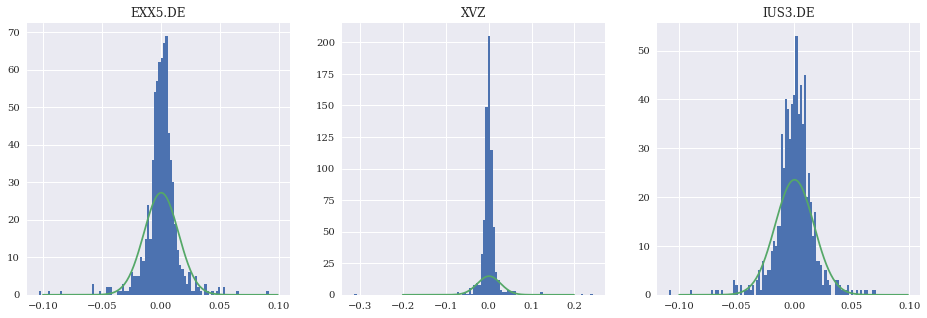

In [15]:
#Histograms
fig, ax = plt.subplots(1,3, figsize = (16,5))
tickers = ["EXX5.DE", "XVZ", "IUS3.DE"]
x = 0
x_dens = [np.arange(-0.1,0.1, 0.001), np.arange(-0.2,0.2, 0.001), np.arange(-0.1,0.1, 0.001)]

for ticker in tickers:
    ax[x].hist(Log_returns[ticker], bins = 100)
    ax[x].plot(x_dens[x], stats.norm.pdf(x_dens[x], Log_returns[ticker].mean(), Log_returns[ticker].std()))
    ax[x].set_title(ticker)
    x = x+1

- From the histograms we can see that our asset returns have nonsymmetric and leptokurtic characteristics.

In [16]:
#Shapiro-Wilk test 
stat, p = shapiro(Log_returns["EXX5.DE"])
print(f"p value of EXX5: {p}")

stat, p = shapiro(Log_returns["XVZ"])
print(f"p value of XVZ: {p}")

stat, p = shapiro(Log_returns["IUS3.DE"])
print(f"p value of IUS3: {p}")



p value of EXX5: 5.480746724491064e-26
p value of XVZ: 2.2292752801496358e-39
p value of IUS3: 9.674676010086655e-20


- p-values for all our asset returns are less than 0.05. Hence we reject the null hypothesis at 5% level and conclude that the data set is not normally distributed.

## 3.2. Portfolio return and volatility defining

In [17]:
#Covariance matrix
Log_returns.cov()*252

,EXX5.DE,IUS3.DE,XVZ
EXX5.DE,0.054165,0.055078,-0.027387
IUS3.DE,0.055078,0.072207,-0.036276
XVZ,-0.027387,-0.036276,0.183683


 - The variance covariance matrix for the financial instruments to be invested in is the central piece of the portfolio selection process

- We use the pandas built in cov() function to find the covariance matrix. This code gives us annualized covariance matrix

In what follows, we have only long positions and 100% of our wealth will be invested into the portfolio that  consists of our three assets.

In [18]:
#Portfolio weight:
weights = np.random.random(3)
weights = weights/np.sum(weights)

In [19]:
def portfolio_returns(weights):
    return np.sum((Log_returns.mean()*252)*weights)

def portfolio_volaltility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(Log_returns.cov()*252, weights)))

- portfolio_returns() function will give us annual portfolio returns by using the anual returns and given weights of our assets

- portfolio_volaltility() function will calculate the volatility of our portfolio by using variance-covariance matrix and the given weights

- np.dot() function gives the dot product of two vectors/matrices

- The T attribute or transpose() method gives the transpose of a vector or matrix

## 3.3. Efficient portfolios

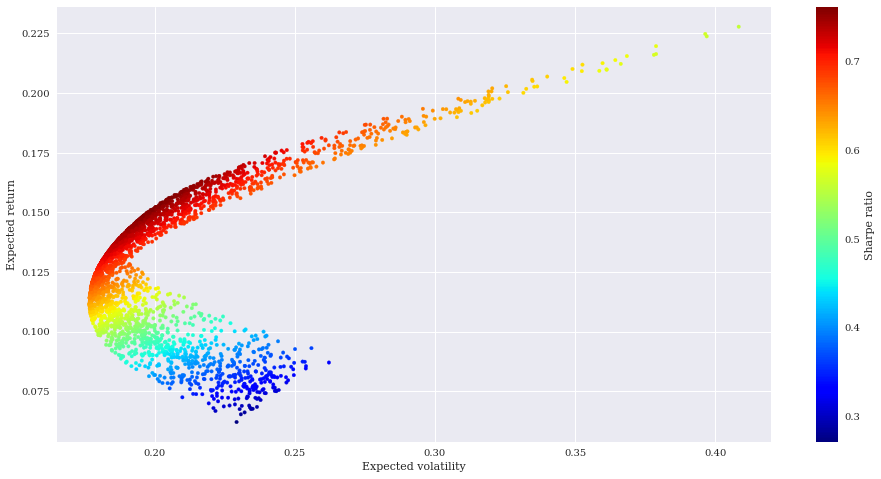

In [20]:
#Monte Carlo simulation
Returns = []
Volatility = []

for p in range (3000):
    weights = np.random.random(3)
    weights /= np.sum(weights)
    Returns.append(portfolio_returns(weights))
    Volatility.append(portfolio_volaltility(weights))
Returns = np.array(Returns)
Volatility = np.array(Volatility)

plt.figure(figsize=(16, 8))
plt.scatter(Volatility, Returns, c=Returns / Volatility, marker='.', cmap='jet')
plt.title("")
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe ratio');

- We create 3000 different portfolios by changing their weights of the assets

- We assign weights with pn.random() function and make sure that sum of the weights is 1

- Returns and Volatility arrays hold the return and volatility of each portfolio respectively

- We use plt.scatter() function to illustrate each portfolio in a scatter-plot

### 3.3.1. Minimum Variance Portfolio

MVP is the portfolio on the efficient frontier that gives the smallest possible expected volatility.

So in order to find the MVP, we have to perform a minimization operation.

We use optimize function from scipy library.

In [21]:
Equality_constraint = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
Bounds = tuple((0, 1) for x in range(3))
Equal_weights = np.array(3*[1. / 3,])

- Equality_constraint is the constraint to make sure that the sum of weights is 1

- Bounds are the boundaries for the parameters / variables. In this case weights

- Equal_weights are just the initial weights to give to our minimization function. We set them to be equal but the function will adjust them

Minimization of the variance leads to the MVP:

In [22]:
MVP = sco.minimize(portfolio_volaltility, Equal_weights, method='SLSQP', bounds=Bounds, constraints=Equality_constraint)
MVP_weights = MVP.x
MVP

     fun: 0.17671635922854403
     jac: array([0.17659908, 0.17626472, 0.17714736])
 message: 'Optimization terminated successfully'
    nfev: 21
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.60296324, 0.11447357, 0.28256319])

MVP return and volatility:

In [23]:
MVP_return = portfolio_returns(MVP_weights)
MVP_volatility = portfolio_volaltility(MVP_weights)
print(f"MVP Return: {MVP_return.round(3)}, MVP Volatility: {MVP_volatility.round(3)}")

MVP Return: 0.113, MVP Volatility: 0.177


### 3.3.2.  Optimal Portfolio by maximizing Sharpe ratio

Here we maximize the Sharpe ratio and find the Optimal Portfolio using the risk free rate of 0.05% which is 3 moths US t-bills.

In [24]:
def minimized_sharpe(weights):
    return -(portfolio_returns(weights)-0.0005) / portfolio_volaltility(weights)

- This function is to be maximized. 

- Because we are using the sco.minimize function for maximization, the function will generate negative values and the minimum of these values will be the maximum sharpe ratio.


Optimal Portfolio:

In [25]:
OP = sco.minimize(minimized_sharpe, Equal_weights, method='SLSQP', bounds=Bounds, constraints=Equality_constraint)
optimal_weights = OP.x
print(f"Optimal Portfolio Return: {portfolio_returns(optimal_weights).round(3)}")
print(f"Optimal Portfolio Volatility: {portfolio_volaltility(optimal_weights).round(3)}")

Optimal Portfolio Return: 0.154
Optimal Portfolio Volatility: 0.202


### 3.3.3 Tangent portfolio identification

Tangential portfolio is the one that lies on the tangecy point where capital market line touches efficient frontier. This portfolio is the same as the portfolio with the highest Sharpe ratio.

#### First, seting up efficient frontier:

In [26]:
Equality_constraints = ({'type': 'eq', 'fun': lambda x:  portfolio_returns(x) - tret},  
                        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) 

Bounds = tuple((0, 1) for x in weights)

Target_returns = np.linspace( 0.103, 0.23, 50)
Target_volatilities = []

for tret in Target_returns:
    res = sco.minimize(portfolio_volaltility, Equal_weights, method='SLSQP', bounds=Bounds, constraints=Equality_constraints)
    Target_volatilities.append(res['fun'])

- To find the efficient frontier we have two constraints, one for target returns and one for the sum of weights as before res() function gives us the minimized target volatility

- tret is the target return. We use it in the constraint to let the function know that for the given volatility level, tret is the highest return and it sould set the equation to 0

- Target_returns is the returns between lowest and the highest returns. This array is created by np.linspace

- Target_volatilities array holds the minimized volatilities

In [27]:
index_mvp = np.argmin(Target_volatilities)
port_vols = Target_volatilities[index_mvp:]
port_rets = Target_returns[index_mvp:]
port_vols = np.sort(port_vols)

- index_mvp is the index position of the MVP

- port_vols and port_rets are the relevant portfolio volatilities and returns to be used in the interpolation function

#### Second, draw the Capital Market Line, we will use interpolation - we use scipy.interpolate package 

In [28]:
interpolate = sci.splrep(port_vols, port_rets)

For that purpose sci.splev() and sci.splev are perfect tools

- sci.splrep function will take our volatilities and returs and based on these values will create a function to predict

- y values - returns that lie on the efficient frontier line. So it creates a function to replicate this line

- sci.splev function evaluates the function from sci.splrep(). der = 0 is the function itself and der=1 is the first order derivative: So f(x) function returns values from the original function and df(x) returns the values from first order derivative of the original function

In [29]:
def f(x):
    return sci.splev(x, interpolate, der=0)

def df(x):
    return sci.splev(x, interpolate, der=1)

- equations() function contains the linear equations for CML

- To solve these equation we use sco.fsolve() function

The equation for the line passes through risk free rate and that is tangent to the efficient frontier:
\begin{equation}t(x)=a+bx\end{equation} 
Three conditions that our function has to satisfy: 
\begin{equation}t(x)=a+bx\end{equation}
\begin{equation}t(0)=a  <=> a = r_{f}\end{equation}
\begin{equation}t(x)=f(x)  <=> a+bx = f(x)\end{equation}
\begin{equation}t'(x)=f'(x)  <=> b = f'(x)\end{equation}

In [30]:
def equations(p, rf=0.0005):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.0005, 0.799, 0.18])

We use minimization again to find the weights of the tangecy portfolio


In [31]:
cons = ({'type': 'eq', 'fun': lambda x:  portfolio_returns(x) - f(opt[2])},{'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
res = sco.minimize(portfolio_volaltility, Equal_weights, method='SLSQP', bounds=Bounds, constraints=cons)

- cons variable holds the two constraints. One as usual for the weights to add up to one and the other saying that find the weights that would set the difference of portfolio_returns evaluated at this weights and the y value for tangency point to 0.

In [32]:
print(f"Tangency Portfolio Return: {portfolio_returns(res['x']).round(3)}")
print(f"Tangency Portfolio Volatility: {portfolio_volaltility(res['x']).round(3)}")

Tangency Portfolio Return: 0.154
Tangency Portfolio Volatility: 0.202


#### Third, we plot our results

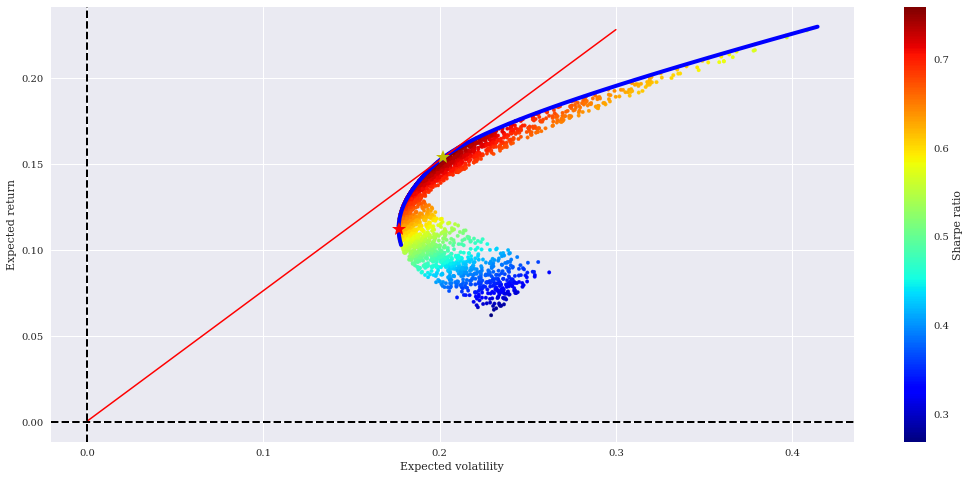

In [33]:
plt.figure(figsize=(18, 8))
plt.scatter(Volatility, Returns, c=(Returns - 0.0005) / Volatility, marker='.',alpha=1, cmap='jet')
plt.plot(Target_volatilities, Target_returns, 'b', lw=4.0)

cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)
plt.plot(opt[2], f(opt[2]), 'y*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)


plt.plot(portfolio_volaltility(MVP['x']), portfolio_returns(MVP['x']), 'r*', markersize=15.0)
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe ratio');

Red star is MVP and yellow star is Tangency Portfolio

## 3.4 Roy's Safety-First Criterion

Because our returns are not normally distributed, other investment tools should be employed to choose the optimal portfolio. For that we use Roy's Safety-First Criterion. Roy's safety-first criterion implies that investors choose their portfolios by minimizing the loss probability for a fixed safety threshold called the floor return and it does not require a specific distribution function. Hence, we basically select a minimum return level rl and choose the portfolio that minimizes the risk of falling below this level. For simplicity we asume that our returns are normally distributed and we choose risk free rate used in Sharpe ratio as floor return.  We take the portfolios created in Monte-Carlo simulation. We compare the z scores of the portfolios and take the lowest z score as the best portfolio. 


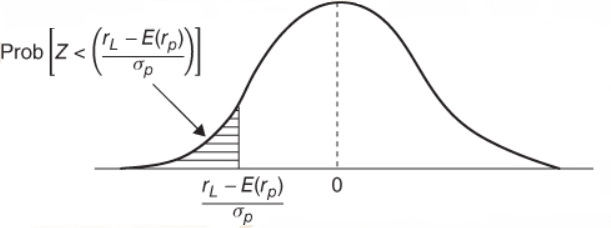

- rl: floor return
- E(rp): expected mean return of portfolio
- Sigma: volatility of portfolio

The portfolio with the smallest area under the curve is the best portfolio

In [50]:
Rl = 0.0005
z_scores = []
for i in range(3000):
    z = (Rl-Returns[i])/Volatility[i]
    z_scores.append(z)

- We take 3000 different portfolios created in Monte-Carlo simulation. Returns and Volatility lists hold the corresponding returns and volatilities for each portfolio

For analytical convenience, we assume that returns are normally distributed and calculate the probabilities of returns decreasing below Rl. However, the normality assumption of asset returns is not necessary for Roy's Safety-First Criterion to work. It also work in non-normal distribution case.

In [51]:
print(f"z score: {min(z_scores).round(3)}")


z score: -0.759


- This is the optimal portfolio according to Roy's safety-first criterion 

We calculate z score for our optimal portfolio with the highest Sharpe ratio

In [52]:
sharpe = (Rl - portfolio_returns(optimal_weights))/portfolio_volaltility(optimal_weights)
prob_tangenial = stats.norm.pdf(sharpe)
print(f"z score: {sharpe.round(3)}")

z score: -0.759


 - As we can see, the z-score of the portfolio from Sharpe Ratio maximization is the same as the z-score from Roy's Safety First criterion. The above exercise was to prove that the Roy's Safety First criterion and Sharpe ratio maximization are identical techniques if the portfolio returns are normally distributed and the risk-free rate is taken as the floor rate.
 - However, if the returns are non-normally distributed, Roy's Safety First criterion is more accurate in finding optimal portfolio.

# Discussion

 The Mean-variance portfolio theory implies a fixed and predictable returns, volatility of element assets and stable correlation between assets return and also the normality assumptions of return rates. These assumptions can be violated in the real world. In our case, we have found the violations of these assumptions in our assets. 

    1. Rates of returns are not normal distributed (refer 3.1)
    2. Correlation between asset returns can vary through time (refer 2.1.3)
    3. Average return and volatilty of elements assets are not constant over time (refer to the exercise below)


- The below codes calculate annualized returns and volatilities for 3 year time frames since 2012
- MPT implies that return and volatility of element assets are constant but as can been seen from  our calculation this implication in fact did not hold

In [53]:
EXX5 = yf.download("EXX5.DE", start= "2010-06-12", end="2021-06-12")
XVZ = yf.download("XVZ", start= "2010-06-12", end="2021-06-12")
IUS3 = yf.download("IUS3.DE", start= "2010-06-12", end="2021-06-12")
ER = yf.download("USDEUR=X", start= "2010-06-12", end="2021-06-12")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [54]:
XVZ = XVZ["Adj Close"]*ER["Adj Close"]
XVZ = XVZ.dropna()

In [55]:
Assets1 = pd.DataFrame(data = {"EXX5": EXX5["Adj Close"],"XVZ": XVZ, 
                              "IUS3": IUS3["Adj Close"]}).dropna()

In [56]:
returns = np.log(Assets1/Assets1.shift(1)).dropna()

In [57]:
tickers = ["EXX5", "XVZ", "IUS3"] 
t = ["2018-06-01", "2015-06-01", "2012-06-01"]
D = []
for ticker in tickers:
    mean1_3 = returns[ticker][t[2]:"2015-06-01"].mean()*252
    mean2_3 = returns[ticker][t[1]:"2018-06-01"].mean()*252
    mean3_3 = returns[ticker][t[0]:"2021-06-01"].mean()*252
    
    std1_3 = returns[ticker][t[2]:"2015-06-12"].std()*math.sqrt(252)
    std2_3 = returns[ticker][t[1]:"2018-06-01"].std()*math.sqrt(252)
    std3_3 = returns[ticker][t[0]:"2021-06-01"].std()*math.sqrt(252)
    
    Data = [{"Return 12 - 15": mean1_3,"Return 15 - 18": mean2_3, 
         "Return 18 - 21": mean3_3, "STD 12 - 15": std1_3,"STD 15 - 18": std2_3, 
         "STD 18 - 21": std3_3}]
    D.append(Data)
    

Mean_std = pd.DataFrame(D[0])
Mean_std = Mean_std.append(D[1], True)
Mean_std = Mean_std.append(D[2], True)
Mean_std.index = ["EXX5", "XVZ", "IUS3"]
Mean_std



,Return 12 - 15,Return 15 - 18,Return 18 - 21,STD 12 - 15,STD 15 - 18,STD 18 - 21
EXX5,0.164915,0.050361,0.059765,0.230492,0.152269,0.232425
XVZ,-0.193328,-0.166923,0.225668,0.161248,0.220603,0.428161
IUS3,0.219434,0.099895,0.092644,0.155758,0.191448,0.268379


# BIBLIOGRAPHY

#### [1] Francis, Jack., and Kim, Dongcheol. (2013): Modern Portfolio Theory: Foundations, Analysis, and New Developments., O'Reilly Media.